# COGS 108 - Final Project (Individual)

# Overview

This project focuses on the association between the frequency of health inspections and health inspection scores. After checking correlation using Spearman's correlation and the difference in means test, the results are that there is little to no association between the frequency of health inspections and health inspection scores. Therefore, having more health inspections will not lead to higher inspection scores.

# Names & PID

- Name: Elise Kim
- PID: A15589538

# Research Question

Does having health inspections more often lead to higher health inspection scores?

## Background and Prior Work

Before learning whether frequent health inspections can lead to higher health inspection scores, factors related to the frequency of health inspections as well as the importance of health inspections are two key topics to discuss. The frequency of health inspections depends on local public health departments. While health inspections occur about twice a year on average, local public health departments increase or lower the frequency of health inspections depending on types of food, food preparation, cross-contamination, and other factors (Food Safety News). As for the importance of health inspections, according to Smith's article "Customer reviews and health inspections drive consistent good hygiene at restaurants," health inspections have long intervals between inspections in which restaurants remain unmonitored. During one of these long intervals, the hygiene quality of about 30% of the restaurants in New York City worsened. <br/><br/>Although there has not been much research into this topic, Dr. Branas, Dr. Glanz, Sara Leinwand, and Brendan Keenan did look into it in their public report "Inspection Frequency, Sociodemographic Factors, and Food Safety Violations in Chain and Nonchain Restaurants." According to their report, an increase in health inspections led to fewer violations for nonchain restaurants, but it did not affect chain restaurants. In addition, regardless of frequency of inspections, nonchain restaurants usually had more violations than chains restaurants. <br/><br/>These three sources are related to my project because my question focuses on the impact of frequency of health inspections on inspection scores. Knowing the factors that determine the frequency of inspections, the benefits of health inspections on hygiene quality, and its effect on the rate of violations are all very important topics to consider. Furthermore, these sources bring up important biases that may affect the data such as frequency depending on locality and food chain versus non-food chain status. 
<br/><br/>References (include links):
- 1) Food Safety News: https://www.foodsafetynews.com/restaurant-inspections-in-your-area/
- 2) 'Customer reviews and health inspections drive consistent good hygiene at restaurants' :https://www.eurekalert.org/pub_releases/2020-01/ifor-cra011320.php
- 3) 'Inspection Frequency, Scoiodemographic Factors, and Food Safety Violations in Chain and Nonchain Restaurants': https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5349477/

# Hypothesis

I think that having more frequent health inspections would lead to higher health inspection scores. A restaurant or other eatery have a lot at risk by not doing well on a health inspection. By having health inspections more often, I would assume an eatery would put more effort into maintaining their hygiene quality until that level of quality becomes a standard at that eatery. 

# Dataset(s)

I will be using inspections.csv and restaurants.csv. Inspections.csv holds a variety of information about different inspections, but I will mainly be using the data of inspection, restaurant name, the restaurant's hsisid, the number of days since last inspection, and the health inspection score. Restaurants.csv holds general information about different restaurants such as their hsisid, location, phone number, name, and more. The only purpose of restaurants.csv is to merge the data with inspections.csv in order to get a list of unique restaurants and their data. The merged dataset should only have the unique id, name of the restaurant, days since previous inspection, and most recent score. Inspections.csv has a total of 18466 different inspections (rows) with 36 different types of information (columns) about each inspection. Restaurants.csv has a total of 3324 different restaurants (rows) with 14 different facts (columns) about each restaurant.

## Setup

In [2]:
# import prep
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest
from scipy.stats import spearmanr

# Data Cleaning

In [3]:
df = pd.read_csv('inspections.csv')
df_restaurants = pd.read_csv('restaurants.csv')

Since inspections.csv has multiple inspections for the same eatery, we need to make sure each row of df has a unique hsisid before merging. We will find the most recent date of inspection and use that row as the data for that restaurant.

In [4]:
for i in range(len(df)):
    dateInt = str(df.iloc[i, 1])
    dateInt = dateInt.replace('-', '')
    dateInt = dateInt[0:dateInt.find('T')]
    df.iloc[i, 1] = int(dateInt)
df = df.loc[df.groupby('hsisid')['date'].idxmax()]

Here, we are merging the two dataframes and selecting the columns that we need. 

In [5]:
df = df.merge(df_restaurants, on='hsisid')
df = df[['hsisid', 'name_x', 'days_since_previous_inspection', 'score']]
df = df.rename({'hsisid': 'id', 'name_x':'name', 'days_since_previous_inspection':'days'}, axis='columns')
df['name'] = df['name'].str.lower()
df = df.dropna()
df.head()

,id,name,days,score
0,4092010018,angus barn,184.0,91.5
1,4092010024,applebee`s,92.0,96.0
2,4092010031,archdale bldg. snack bar,546.0,96.5
3,4092010035,ashworth rexall drug,407.0,92.5
4,4092010037,aubrey & peedi`s grill,269.0,96.5


In [6]:
# checking for any null and uniqueness of responses
df['id'].value_counts()
df['days'].value_counts()
df['score'].value_counts()
df.isna().any()

id       False
name     False
days     False
score    False
dtype: bool

The loop below is to clean the names of the eateries but mainly to ensure restaurants of larger food chains have the same name to prepare for usage of groupby(). Please look at the comments for further information about specifics about the loop.

In [8]:
for i in range(len(df)):
    resName = df.iloc[i, 1]
    # removing parentheses and hashtags
    ParenIndex = resName.find('(')
    EndParenIndex = resName.find(')')
    if (ParenIndex != -1) & (EndParenIndex != -1):
        resName = resName.replace(resName[ParenIndex:EndParenIndex+1], '')
    hashIndex = resName.find('#')
    if (hashIndex != -1):
        resName = resName.replace(resName[hashIndex:resName.find(' ', hashIndex)], '')
        
    # finding larger food chains
    if 'walmart' in resName:
        resName = 'walmart'
    if 'starbucks' in resName:
        resName = 'starbucks'
    if 'harris teeter' in resName:
        resName = 'harris teeter'
    if 'barnes' in resName:
        resName = 'barnes & nobles'
    if 'amedeo' in resName:
        resName = 'amedeos'
    if 'denny' in resName:
        resName = 'dennys'
    if 'brueggers' in resName:
        resName = 'brueggers bagels'
    if 'jersey mikes' in resName:
        resName = 'jersey mikes'
    if 'bjs' in resName:
        resName = 'bjs club'
        
    # general cleaning (spelling errors, unique words, etc.)
    resName = resName.replace('deli', '')
    resName = resName.replace('produce', '')
    resName = resName.replace('meat market', '')
    resName = resName.replace('meat market/seafood', '')
    resName = resName.replace('cicle', 'circle')
    resName = resName.replace('bage ', 'bagels')
    resName = resName.replace('dorton arena', '')
    resName = resName.replace('/bakery', '')
    resName = resName.replace('&amp;', '&')
    resName = resName.replace('&amp', '&')
    resName = resName.replace(' and ', '&')
    resName = resName.replace(' & ', '&')
    resName = resName.replace('&', ' & ')
    resName = resName.replace("`s", 's')
    resName = resName.replace("'s", 's')
    resName = resName.replace('  ', ' ')
    resName = resName.replace('@', 'at')
    resName = resName.replace('0', '')
    resName = resName.replace('1', '')
    resName = resName.replace('2', '')
    resName = resName.replace('3', '')
    resName = resName.replace('4', '')
    resName = resName.replace('5', '')
    resName = resName.replace('6', '')
    resName = resName.replace('7', '')
    resName = resName.replace('8', '')
    resName = resName.replace('9', '')
    resName = resName.replace('ii', '')
    resName = resName.replace(' - ', ' ')
    resName = resName.replace('-', ' ')
    
    # removing all phrases related to location or owner
    resName = resName.replace(' by ', '$')
    resName = resName.replace(' at ', '$')
    dollarIdx = resName.find('$')
    if (dollarIdx != -1):
        resName = resName[0:dollarIdx]
    resName = resName.strip()
    df.iloc[i, 1] = resName

df['name'].value_counts()[:10]

food lion        122
harris teeter     86
subway            63
mcdonalds         49
starbucks         37
lowes foods       23
jersey mikes      22
kroger            21
bojangles         20
chick fil a       20
Name: name, dtype: int64

Grouping restaurants of larger food chains and creating new dataframe with each unique name as its own row

In [9]:
finaldf = df.groupby('name').days.mean().to_frame('days').reset_index()
scoredf = df.groupby('name').score.mean().to_frame('score').reset_index()
finaldf = finaldf.merge(scoredf, on='name')
print(finaldf.head())

                  name   days      score
0    a & c supermarket  260.0  94.500000
1      a & k food mart  262.0  96.500000
2  a slice of ny pizza  184.0  97.000000
3  a taste of new york  187.0  96.833333
4         a'nets katch  223.0  97.500000


# Data Analysis and Results

Before looking into the relationship between days since previous inspection and health inspection scores, we will first look into each variable separately.

Text(0.0, 1.0, 'Frequency of Days Since Previous Inspection')

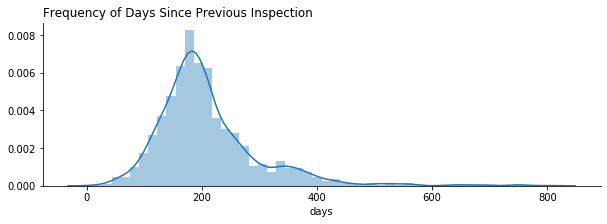

In [168]:
# df.hist(column='days', grid=False)
fig, ax = plt.subplots(figsize=(10, 3))
dayHist = sns.distplot(finaldf['days'])
# Hide the right and top spines
dayHist.spines['right'].set_visible(False)
dayHist.spines['top'].set_visible(False)
dayHist.set_title('Frequency of Days Since Previous Inspection', loc='left')

This histogram shows the frequency of days since a restaurant has last had an inspection. Looking at this histogram, we can see that the mean is a little under 200 days (~180 days). There does not appear to be any outliers, but the shape of the distribution is skewed right. From this histogram, we know that most eateries have inspections within 400 days (13.33 months).

Text(0.0, 1.0, 'Frequency of Scores')

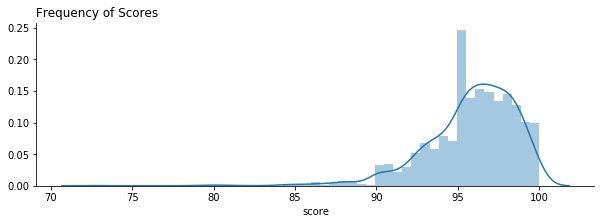

In [169]:
fig, ax = plt.subplots(figsize=(10, 3))
scoreHist = sns.distplot(finaldf['score'])
# Hide the right and top spines
scoreHist.spines['right'].set_visible(False)
scoreHist.spines['top'].set_visible(False)
scoreHist.set_title('Frequency of Scores', loc='left')

This histogram shows the frequency of each inspection score. Looking at this histogram, we can see that the mean is a score of around 97. There does not appear to be any outliers, but the shape of the distribution is skewed left. From this histogram, we know that most scores tend to be above 90. 

Now, we will look into the relationship between the two variables.

Text(0.0, 1.0, 'Score by Day')

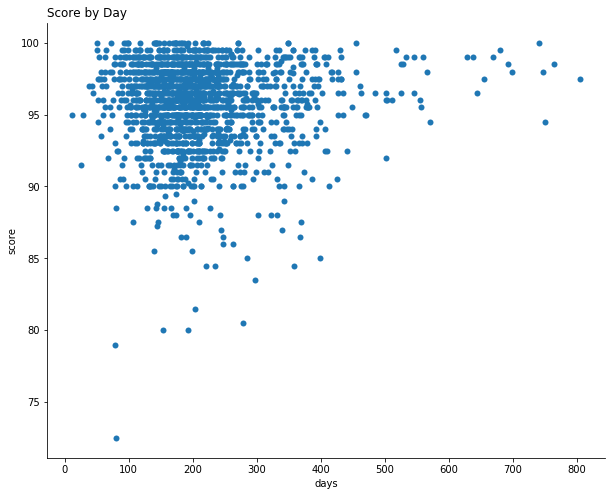

In [170]:
fig, ax = plt.subplots(figsize=(10, 8))
scatterScore = sns.scatterplot(x='days', y='score', data=finaldf[['days', 'score']], linewidth=0)
scatterScore.spines['right'].set_visible(False)
scatterScore.spines['top'].set_visible(False)
scatterScore.set_title('Score by Day', loc='left')

This scatterplot shows the relationship between inspection score and days since last inspection. We can see that most of the data points are bunched up in the top left corner, meaning most places have had their last health inspection in the last 400 days (13.33 months) and mostly received scores above 90 on their most recent health inspection, which match both of the histograms above. We can also see that most of the scores below 90 are from eateries that have had a health inspection in the last 400 days. However, there are also much more data points within 400 days. We will test for correlation later to see whether the majority of lower scores being within the 400 days is due to having more frequent health inspections or just due to chance. Since most of the points are bunched up, there does not appear to be a linear relationship between the two variables, meaning we cannot use linear regression or Pearson correlation, which depend on the assumption of linearity. 

Since we cannot use linear regression or Pearson correlation, we will use Spearman's correlation instead. 

In [171]:
data1 = finaldf['days']
data2 = finaldf['score']
coef, p = spearmanr(data1, data2)
alpha = 0.01
if p < alpha:
    print('Samples are correlated')
else:
    print('Not correlated')

Not correlated


The cell above checks for the association between days since last inspection and the most recent health inspection score. Since the p-value was greater than 0.01, it is unlikely that they are correlated according to Spearman's correlation.

According to Spearman's correlation, the days since last inspection and most recent health inspection score are not correlated. However, we can also test using a difference in means test (t-test). Here, we will convert days into 'Binary Days' which only has an input of 0 and 1 depending on the day average.

In [172]:
dayAvg = finaldf['days'].mean()
finaldf['BinaryDays'] = finaldf['days'].apply(lambda x: 0 if x < dayAvg else 1)
finaldf.groupby(['BinaryDays'])['score'].mean()
group1 = finaldf.where(finaldf.BinaryDays==0).dropna()['score']
group2 = finaldf.where(finaldf.BinaryDays==1).dropna()['score']
ttest_ind(group1, group2)

Ttest_indResult(statistic=0.531668442832363, pvalue=0.5950202533445049)

Since the p-value of 0.5336 is greater than 0.01, observing this difference in means due to random chance alone is likely. Therefore, we fail to reject the null hypothesis, concluding that the difference in means is not significant and that how often a restaurant has health inspections does not play a role on its inspection score.

## Results
According to both Spearman's correlation and the difference in means test, there is no association between days since last inspection and the most recent inspection score. Since there is no association, we can conclude that having health inspections more often, or, in other words, less days since last inspection, does not lead to higher inspection scores. 

# Ethics & Privacy

I do have permission to use both inspections.csv and restaurants.csv as data for this project. I do not think there are any privacy concerns regarding my data. A restaurant's name and health inspection score are both information open to the public. As for potential biases in my dataset, since restaurants of a food chain may have similar health policies, having each individual restaurant of a food chain as its own observation may affect the data. In addition, since local health departments decide the frequency of health inspections, the results can hurt restaurants in a specific locality depending on the frequency. <br/> <br/>
As for how I will handle these issues, a restaurant's name is only used to combine food chains as one entry and is not shown on any graphs or written directly in the data analysis or results. If a name is absolutely necessary, a unique id can be given to each restaurant specifically for this project to ensure all restaurants remain anonymous. Therefore, data privacy should not be an issue. For the bias of food chains, as I stated above, restaurants of a food chain can be combined to be a single observation rather than each being their own observation. The days since the previous inspection and the health inspection score can be determined by averaging the two variables between all restaurants of that food chain. With the issue of local health departments determining frequency of health inspections, there is not much I can do to my data to change it. However, since all names will be unknown and addresses will not be used in my dataset, the results should not affect specific restaurants.


# Conclusion & Discussion

My project focused on the relationship between the frequency of health inspections and health inspection scores. Using unique restaurants, the number of days since their last inspection, and their most recent inspection score, I compared each restarant's most recent inspection score and the number of days in order to see if there was some correlation between the two. Contrary to my hypothesis, both Spearman's correlation and the difference in means test demonstrated that there was no correlation between the frequency of health inspections and health inspection scores, meaning the frequency of health inspections does not lead to higher health inspection scores. <br/> <br/>As for a limitation of my project, it may have been better to also look into the previous scores of each restaurant. I did not consider using it until after I completed the data analysis. I was unsure of whether there would be enough data since it would heavily reduce the number of observations I could use in inspections.csv. In addition, another limitation is that my project does not look into other factors that may impact a restaurant's health inspection score. For instance, Harvard's research showing that health inspections scheduled later in the day may receive higher scores due to health inspectors being more exhausted is another factor that could be affecting health inspection scores ('Harvard researchers say fixing food safety inspectors' schedules could end many violations').  <br/> <br/> Since my project has shown that there is no correlation between the frequency of health inspections and health inspection scores, public health departments can take this information to focus on other aspects that may improve food safety and health violation rates. Instead of focusing funding on having more health inspections, which can already be quite expensive, health departments can look into changing the schedules of food inspectors as discussed in the Harvard research above or test other methods for the sake of food safety.